In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# run only once
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSIs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MSIs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import pandas as pd
import glob
import os

import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress Bar

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score,precision_score, recall_score, f1_score


import transformers
from transformers import logging as hf_logging
from transformers import AutoTokenizer, AutoModel, TFAutoModel

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense,Activation,Dropout, SpatialDropout1D 
from tensorflow.keras.layers import BatchNormalization, Input, Embedding, LSTM 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

hf_logging.set_verbosity_error() # Hidding Huggingface Warnings

## Read Data

In [4]:
path='dataset/Vietnamese Text Readability Corpus/'

In [5]:
def read_text_files(files):
  data=pd.DataFrame()
  texts=[]
  labels=[]

  path=os.path.join(files, '*.txt')

  for txt_file in glob.glob(path):
    lbl=txt_file.split('/')[-1].split('\\')[-1].split('_')[0]
#     print(lbl)
    text=open(txt_file,'r', encoding="utf8").read().replace('\n',' ')

    texts.append(text)
    labels.append(lbl)
  data['text']=texts
  data['label']=labels
  return data

In [6]:
df = read_text_files(path)
df['text'].head()

0    Khái niệm diễn ngôn trong nghiên cứu văn học h...
1    Tư tưởng nữ học của Đạm Phương nữ sử Trong bài...
2    Bí thuật của nghề nghiệp 1 . Người muốn là xạ ...
3    Vài suy tư về Kafka Tác phẩm của Kafka là một ...
4    Người kể chuyện tự ý thức trong Nỗi buồn chiến...
Name: text, dtype: object

In [7]:
df.to_csv("dataset.csv", index=False)

# Preprocessing
## GPU Check

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')

## Utils Functions

In [9]:
def count_digit(num):
    count = 0
    while num != 0:
        num //= 10
        count += 1
    return count

def check_shape(df):
    rows, cols = df.shape
    print("\nNumber or rows in dataset: {}".format(rows))
    print("==========================={}".format(count_digit(rows)*'='))
    print("\nNumber or columns in dataset: {}".format(cols))
    print("=============================={}".format(count_digit(cols)*'='))
    
def modelEvaluation(predictions, y_test_set, model_name, classes):
    # Print model evaluation to predicted result    
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))    
    print ("\nClassification report : \n", classification_report(y_test_set, predictions, target_names = classes))
#     print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set,predictions))
    sns.heatmap(confusion_matrix(y_test_set, predictions),annot=True,yticklabels=classes, xticklabels=classes, fmt='g',cmap='jet')
   
    plt.tight_layout()
    plt.show()
    results = [accuracy_score(y_test_set, predictions), precision_score(y_test_set, predictions,average='macro'),
              recall_score(y_test_set, predictions,average='macro'),f1_score(y_test_set, predictions,average='macro')]#store results of model
    return results

## Text Cleaning

In [10]:
df['text'] = df['text'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))  # lower case conversion
df['text'] = df['text'].str.replace('[^\w\s]', '')  # getting rid of special characters
df['text'] = df['text'].str.replace('\d+',
                                                        '')  # removing numeric values from between the words
df['text'] = df['text'].apply(
    lambda x: x.translate(string.digits))  # removing numerical numbers
stop = stopwords.words('english')
df['text'] = df['text'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))  # removing stop words

## Class Distribution Analysis

veryeasy     809
easy         453
difficult    321
medium       242
Name: label, dtype: int64

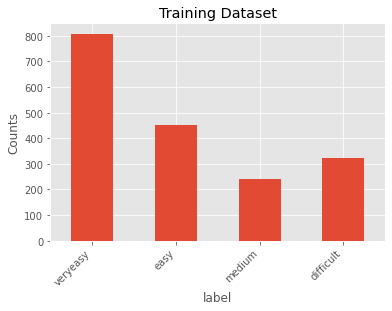

In [11]:
reorder = ['veryeasy', 'easy', 'medium', 'difficult']

plt.style.use('ggplot')
df.value_counts('label').reindex(index=reorder).plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Training Dataset')
plt.ylabel('Counts')
df.label.value_counts()

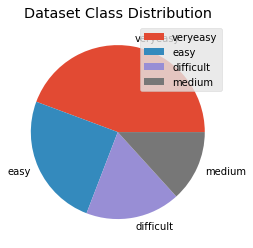

In [12]:
classes_counts = df.value_counts('label')
values = np.array(classes_counts)
mylabels = list(classes_counts.index)

plt.pie(values, labels = mylabels)
plt.legend()
plt.title('Dataset Class Distribution')
# plt.ylabel('Counts')
plt.show() 


## Most Frequently Used Word Analysis

Text(0, 0.5, 'Counts')

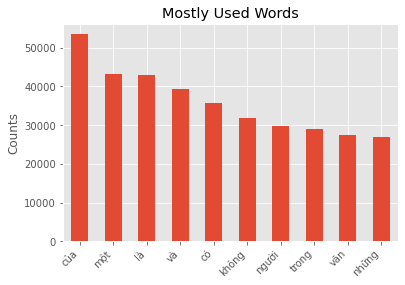

In [13]:
taxfreq = pd.Series(' '.join(df['text']).split()).value_counts()[:10]
taxfreq.plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Mostly Used Words')
plt.ylabel('Counts')

## Label Encoder

In [14]:
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])
df.head()

,text,label,encoded_label
0,khái niệm diễn ngôn trong nghiên cứu văn học h...,difficult,0
1,tư tưởng nữ học của đạm phương nữ sử trong bài...,difficult,0
2,bí thuật của nghề nghiệp người muốn là xạ thủ ...,difficult,0
3,vài suy tư về kafka tác phẩm của kafka là một ...,difficult,0
4,người kể chuyện tự ý thức trong nỗi buồn chiến...,difficult,0


## Feature Extraction

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=200)
X = vectorizer.fit_transform(df['text'])
y = df['encoded_label']

## Train Test Split

In [16]:
X = vectorizer.fit_transform(df['text'])
y = df['label']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=123)

Text(0.5, 0, 'Documnet Label')

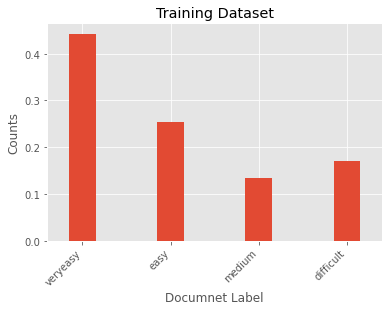

In [17]:
y_train.value_counts('label').reindex(index=reorder).plot(kind='bar', width=0.3)
# plt.sca(ax1)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Training Dataset')
plt.ylabel('Counts')
plt.xlabel('Documnet Label')

Text(0.5, 0, 'Documnet Label')

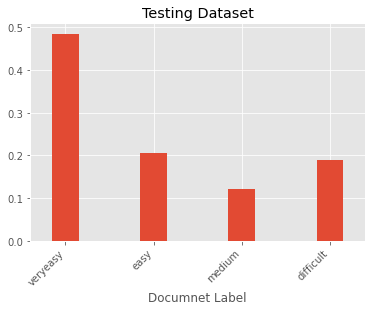

In [18]:
reorder = ['veryeasy', 'easy', 'medium', 'difficult']


y_test.value_counts('label').reindex(index=reorder).plot(kind='bar', width=0.3)
# plt.sca(ax2)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Testing Dataset')
plt.xlabel('Documnet Label')


Text(0.5, 0, 'Documnet Label')

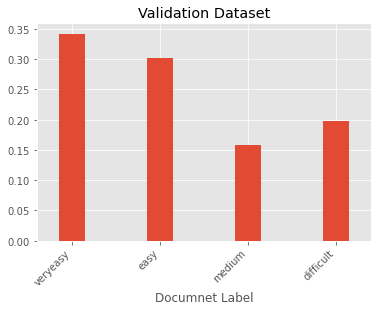

In [19]:
y_val.value_counts('label').reindex(index=reorder).plot(kind='bar', width=0.3)
# plt.sca(ax3)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Validation Dataset')
plt.xlabel('Documnet Label')

In [20]:
y_train

1074    veryeasy
354         easy
1465    veryeasy
769         easy
478         easy
          ...   
1213    veryeasy
1053    veryeasy
438         easy
576         easy
720         easy
Name: label, Length: 1314, dtype: object

In [21]:
X = vectorizer.fit_transform(df['text'])
y = df['encoded_label']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=123)

check_shape(X_train)
check_shape(X_test)
check_shape(X_val)


Number or rows in dataset: 1314

Number or columns in dataset: 200

Number or rows in dataset: 365

Number or columns in dataset: 200

Number or rows in dataset: 146

Number or columns in dataset: 200


# Machine Learning

In [22]:
 classes = list(df.label.unique())
collect_results_of_all_model= {
    'Metrics':['accuracy','precision','recall','f1-score']
}#dic form store results of all models

## SVM Model

In [23]:
from sklearn.svm import SVC

SVC_classifier = SVC(max_iter=200)
SVC_classifier.fit(X_train,y_train)

preds = SVC_classifier.predict(X_test)

## Result

========== SVC ==========

Accuracy on validation set: 0.8575

Classification report : 
               precision    recall  f1-score   support

   difficult       0.91      1.00      0.95        69
        easy       0.69      0.81      0.75        75
      medium       0.68      0.34      0.45        44
    veryeasy       0.94      0.95      0.94       177

    accuracy                           0.86       365
   macro avg       0.81      0.78      0.77       365
weighted avg       0.85      0.86      0.85       365



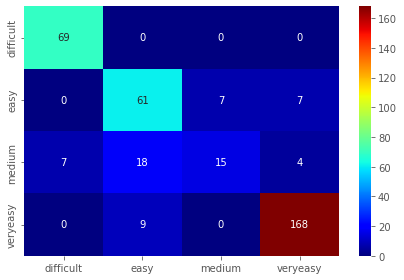

In [24]:
SVC_res=modelEvaluation(preds, y_test, 'SVC', classes)
collect_results_of_all_model["SVC"] = SVC_res

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF_model=RF.fit(X_train,y_train)

preds_RF = RF.predict(X_test)

## Results

========== RF_CLassifier ==========

Accuracy on validation set: 0.9315

Classification report : 
               precision    recall  f1-score   support

   difficult       0.93      1.00      0.97        69
        easy       0.82      0.96      0.88        75
      medium       0.96      0.52      0.68        44
    veryeasy       0.98      0.99      0.99       177

    accuracy                           0.93       365
   macro avg       0.92      0.87      0.88       365
weighted avg       0.94      0.93      0.92       365



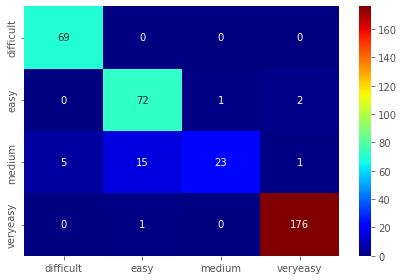

In [26]:
RF_res = modelEvaluation(preds_RF, y_test, 'RF_CLassifier', classes)
collect_results_of_all_model["RF_CLassifier"] = RF_res

## KNN Model

In [27]:
from sklearn.neighbors import KNeighborsClassifier

neighbors_clf = KNeighborsClassifier(n_neighbors=5,)
neighbors_clf.fit(X_train,y_train)

KNN_preds = neighbors_clf.predict(X_test)

## Results

========== KNN_test ==========

Accuracy on validation set: 0.4740

Classification report : 
               precision    recall  f1-score   support

   difficult       0.85      1.00      0.92        69
        easy       0.26      0.39      0.31        75
      medium       0.24      0.68      0.35        44
    veryeasy       0.98      0.25      0.40       177

    accuracy                           0.47       365
   macro avg       0.58      0.58      0.50       365
weighted avg       0.72      0.47      0.48       365



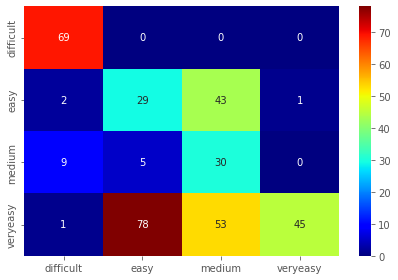

In [28]:
KNN_res = modelEvaluation(KNN_preds,y_test,'KNN_test',classes)
collect_results_of_all_model["KNN"] = KNN_res

## Customize CNN

In [29]:
y_train

1074    3
354     1
1465    3
769     1
478     1
       ..
1213    3
1053    3
438     1
576     1
720     1
Name: encoded_label, Length: 1314, dtype: int32

In [30]:
y_train1 = to_categorical(y_train, num_classes=4)
y_test1 = to_categorical(y_test, num_classes=4)
y_val1 = to_categorical(y_val, num_classes=4)

In [31]:
X_train = X_train.toarray()
X_test = X_test.toarray()
X_val = X_val.toarray()

In [32]:
model = Sequential()
model.add(Dense(150, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               30150     
                                                                 
 dense_1 (Dense)             (None, 100)               15100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 15)                390       
                                                                 
 dense_5 (Dense)             (None, 10)                160       
                                                                 
 dense_6 (Dense)             (None, 4)                 4

In [33]:
batch_size = 32
model.fit(X_train, y_train1, validation_data=(X_val, y_val1), epochs = 15, batch_size=batch_size, verbose = 1)

Epoch 1/15
42/42 [==============================] - 3s 22ms/step - loss: 1.2542 - accuracy: 0.5845 - val_loss: 1.1025 - val_accuracy: 0.5205
Epoch 2/15
42/42 [==============================] - 0s 4ms/step - loss: 0.9065 - accuracy: 0.6393 - val_loss: 0.8394 - val_accuracy: 0.7260
Epoch 3/15
42/42 [==============================] - 0s 2ms/step - loss: 0.7184 - accuracy: 0.7336 - val_loss: 0.7700 - val_accuracy: 0.7055
Epoch 4/15
42/42 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.7763 - val_loss: 0.7070 - val_accuracy: 0.7740
Epoch 5/15
42/42 [==============================] - 0s 3ms/step - loss: 0.5648 - accuracy: 0.8128 - val_loss: 0.7183 - val_accuracy: 0.8082
Epoch 6/15
42/42 [==============================] - 0s 6ms/step - loss: 0.5090 - accuracy: 0.8417 - val_loss: 0.6584 - val_accuracy: 0.8014
Epoch 7/15
42/42 [==============================] - 1s 15ms/step - loss: 0.4826 - accuracy: 0.8554 - val_loss: 0.6212 - val_accuracy: 0.7740
Epoch 8/15
42/42 [

## Results

In [34]:
# make prediction using trained model
predictions = model.predict(X_test)
# calculate accuracy and other evaluation measures
y_pred = [np.argmax(prediction) for prediction in predictions]

12/12 [==============================] - 0s 2ms/step


========== NN_test ==========

Accuracy on validation set: 0.8329

Classification report : 
               precision    recall  f1-score   support

   difficult       0.96      0.96      0.96        69
        easy       0.62      0.71      0.66        75
      medium       0.60      0.73      0.66        44
    veryeasy       0.97      0.86      0.92       177

    accuracy                           0.83       365
   macro avg       0.79      0.81      0.80       365
weighted avg       0.85      0.83      0.84       365



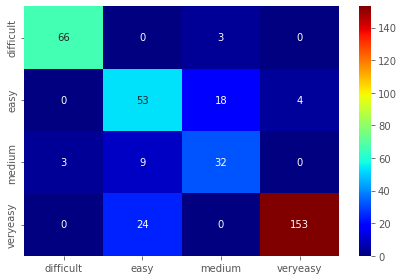

In [35]:
NN_res = modelEvaluation(y_pred, y_test,'NN_test',classes)
collect_results_of_all_model["NN"] = NN_res

In [36]:
SVC_res

[0.8575342465753425,
 0.8053605557189062,
 0.7758487416538264,
 0.7746390187160754]

In [37]:
collect_results_of_all_model["Roberta"] = [0.9672342465753425, 0.9745642449907422, 0.9739278376990242, 0.9734472611754559]

# Results Comparison
## Comparison Table

In [38]:
from tabulate import tabulate 
metrics_data_frame = pd.DataFrame(collect_results_of_all_model)#create dataframe
metrics_data_frame = metrics_data_frame.set_index('Metrics')#set index
# displaying the DataFrame
print(tabulate(metrics_data_frame, headers = 'keys', tablefmt = 'psql'))#convert results in to table

+-----------+----------+-----------------+----------+----------+-----------+
| Metrics   |      SVC |   RF_CLassifier |      KNN |       NN |   Roberta |
|-----------+----------+-----------------+----------+----------+-----------|
| accuracy  | 0.857534 |        0.931507 | 0.473973 | 0.832877 |  0.967234 |
| precision | 0.805361 |        0.923047 | 0.581784 | 0.787774 |  0.974564 |
| recall    | 0.775849 |        0.869269 | 0.580681 | 0.813717 |  0.973928 |
| f1-score  | 0.774639 |        0.878426 | 0.496672 | 0.797717 |  0.973447 |
+-----------+----------+-----------------+----------+----------+-----------+


Text(0.5, 0, 'Evaluation Measure')

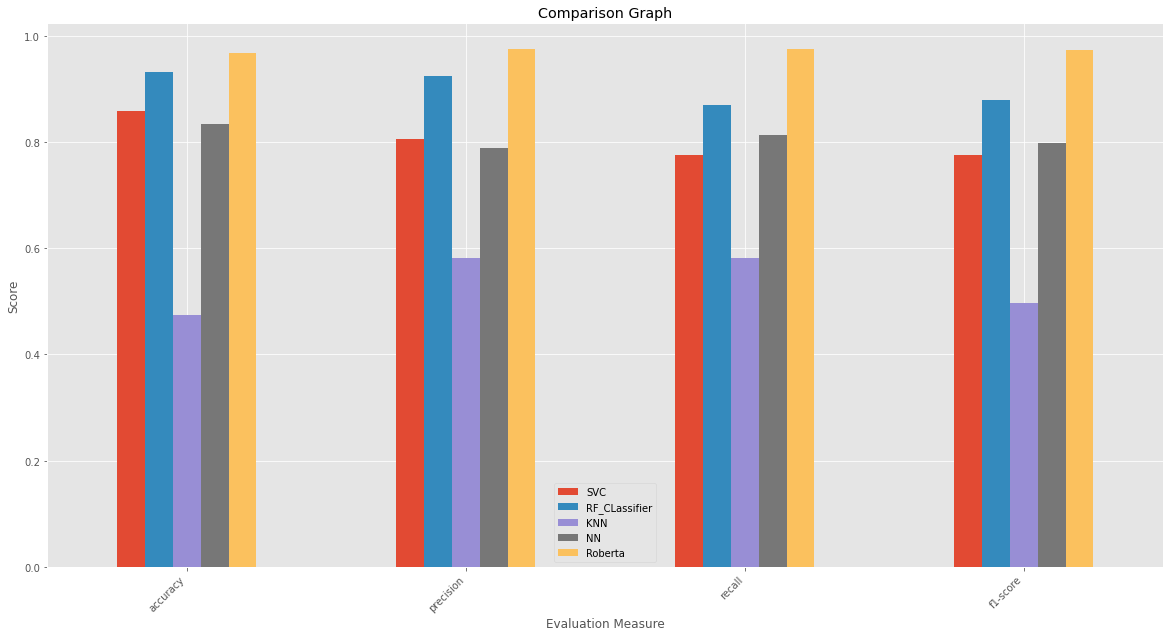

In [39]:
metrics_data_frame.plot(kind='bar', figsize=(20,10)) #sho comparison base of mertics
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Comparison Graph')
plt.ylabel('Score')
plt.xlabel("Evaluation Measure")